In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
%run 'yolov3_tf2.ipynb'

In [3]:
%run 'utils.ipynb'

In [4]:
model_size = (416, 416, 3)
class_name = './data/classes.txt'
max_output_size = 40
max_output_size_per_class = 20
iou_threshold = 0.5
confidence_threshold = 0.5

cfgfile = 'cfg/yolov3.cfg'
weightfile = 'weights/yolov3_weights.tf'
img_path = 'img/host-a004_cam0_1232815252251064006.jpeg'

In [14]:
num_classes = 80
model = YOLOv3Net(cfgfile,model_size,num_classes)
model.load_weights(weightfile)

class_names = load_class_names(class_name)
    
image = cv2.imread(img_path)
#image = plt.imread(img_path)
image = np.array(image)
image = tf.expand_dims(image, 0)

resized_frame = resize_image(image, (model_size[0],model_size[1]))
pred = model.predict(resized_frame)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 416, 416, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
____________________________________________________________________________________________

In [15]:
classes

<tf.Tensor: id=11484, shape=(1, 40), dtype=float32, numpy=
array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 7., 7., 7., 5., 0., 7., 7., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

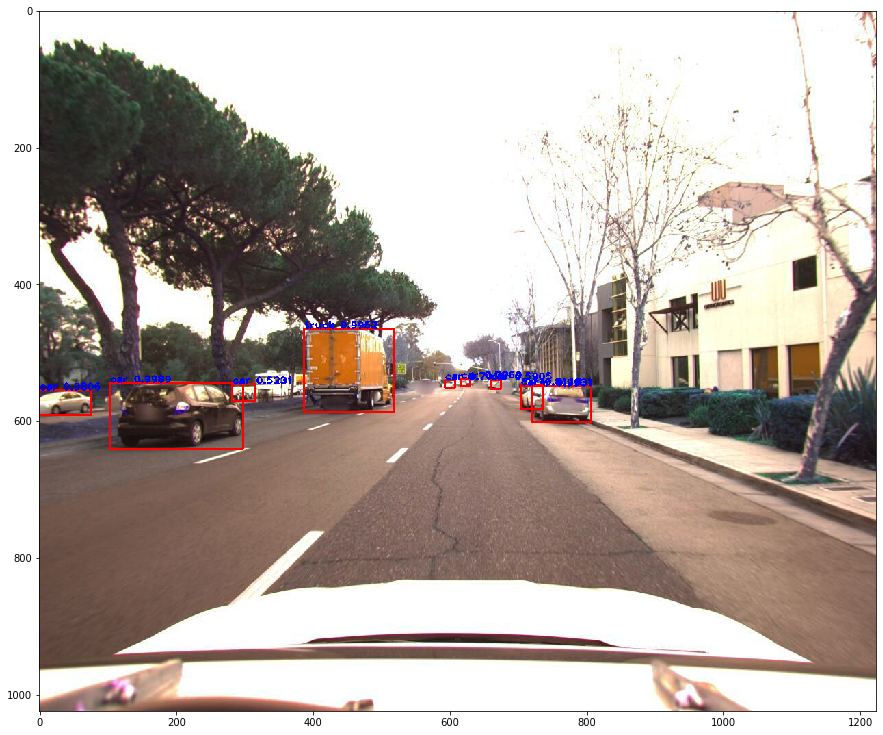

In [16]:
boxes, scores, classes, nums = output_boxes(
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)
image = np.squeeze(image)
img = draw_outputs(image, boxes, scores, classes, nums, class_names)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,15))
plt.imshow(img)
plt.savefig('final_img/test.png')

In [17]:
win_name = 'Image detection'
#cv2.imshow(win_name, img)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite('final_img/host-a004_cam0_1232815252251064006.jpeg', img)

True